# Understanding Credal Sets and Uncertainty in Machine Learning

This notebook explores the concept of **Credal Sets**, a powerful tool from the field of *Imprecise Probabilities*. We will visualize how they differ from standard probability distributions and demonstrate how they can be used with **Deep Ensembles** to better quantify uncertainty.

### Table of Contents
1.  **What is a Credal Set?** (Theory & Intuition)
2.  **Visualizing the Probability Simplex**
3.  **From Point Estimates to Sets**
4.  **Application: Uncertainty in Ensembles**
    * Consensus (Low Uncertainty)
    * Conflict (High Epistemic Uncertainty)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

# Configuration for clearer plots
plt.style.use("seaborn-v0_8-whitegrid")
np.random.seed(42)

print("Libraries imported successfully.")

Libraries imported successfully.


## 1. What is a Credal Set?

In standard Machine Learning (e.g., using Softmax), a model outputs a single probability distribution vector $p$. For a 3-class problem, this might look like $p = [0.7, 0.2, 0.1]$. This is called a **point estimate**.

However, a single point cannot always express "I don't know." It conflates:
1.  **Aleatoric Uncertainty:** The world is noisy (e.g., flipping a coin).
2.  **Epistemic Uncertainty:** The model lacks knowledge (e.g., never seen this image type before).

**A Credal Set $\mathcal{K}$** is not a single distribution, but a **set of probability distributions**. Instead of saying "the probability is 0.7," we say "the probability is somewhere inside this region."

### Mathematical Definition
If $\Delta$ is the probability simplex (the space of all possible probability distributions), a Credal Set $\mathcal{K}$ is a closed, convex subset of $\Delta$.
$$\mathcal{K} \subseteq \Delta$$

## 2. Visualizing the Probability Simplex

To understand Credal Sets, we must visualize the **Simplex**. For 3 classes, the simplex is a triangle. Every point inside the triangle represents a valid probability distribution (summing to 1).

* **Corners:** 100% certainty for one class.
* **Center:** Complete uncertainty ($[1/3, 1/3, 1/3]$).

Let's define a helper function to project 3D probability vectors onto a 2D triangle.

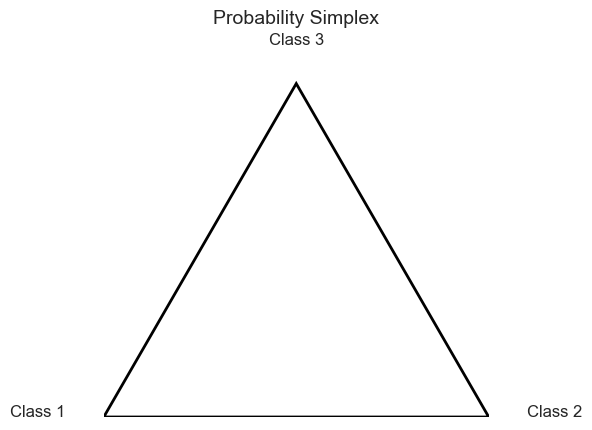

In [ ]:
def project_to_simplex(points: np.ndarray) -> np.ndarray:
    """Projects 3D probability vectors (p1, p2, p3) onto a 2D equilateral triangle.
    Uses a standard barycentric mapping.
    """  # noqa: D205
    points = np.array(points)
    x = 0.5 * (2 * points[:, 1] + points[:, 2]) / (points.sum(axis=1))
    y = 0.5 * np.sqrt(3) * points[:, 2] / (points.sum(axis=1))
    return np.column_stack((x, y))


def plot_simplex(ax: plt.Axes, title: str = "Probability Simplex") -> np.ndarray:
    """Draws the background triangle for the simplex."""
    # Corners of the triangle (One-hot vectors)
    corners_3d = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    corners_2d = project_to_simplex(corners_3d)

    # Draw the triangle boundaries
    triangle = plt.Polygon(corners_2d, fill=False, edgecolor="black", linewidth=2)
    ax.add_patch(triangle)

    # Label corners
    ax.text(corners_2d[0, 0] - 0.1, corners_2d[0, 1], "Class 1", fontsize=12, ha="right")
    ax.text(corners_2d[1, 0] + 0.1, corners_2d[1, 1], "Class 2", fontsize=12, ha="left")
    ax.text(corners_2d[2, 0], corners_2d[2, 1] + 0.1, "Class 3", fontsize=12, ha="center")

    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(title, fontsize=14)
    return corners_2d


# Test the plot to see the empty Simplex
fig, ax = plt.subplots(figsize=(6, 5))
plot_simplex(ax)
plt.show()

## 3. From Point Estimates to Sets

In a **Deep Ensemble**, we train $M$ different models. For a given input, we get $M$ different probability vectors.

* **Standard approach:** Average the vectors. This gives a single point (the mean).
* **Credal approach:** Consider the **Convex Hull** of all these vectors. This area represents the Credal Set.

The **size** of this set represents our **Epistemic Uncertainty**.
* **Small Set:** All models agree (High confidence).
* **Large Set:** Models disagree significantly (We are ignorant about the truth).

In [ ]:
def plot_credal_set(ax: plt.Axes, predictions: np.ndarray, color: str = "blue", label: str = "Credal Set") -> None:
    """Plots the individual predictions and the Convex Hull (Credal Set)."""
    coords = project_to_simplex(predictions)

    # Plot individual model predictions (points)
    ax.scatter(coords[:, 0], coords[:, 1], c=color, s=60, alpha=0.8, edgecolors="k", label="Ensemble Members")

    # Calculate and plot Convex Hull if we have enough points (>=3)
    # The Convex Hull is the smallest convex set containing all points
    if len(coords) >= 3:
        try:
            hull = ConvexHull(coords)
            for simplex in hull.simplices:
                ax.plot(coords[simplex, 0], coords[simplex, 1], color=color, linewidth=2)

            # Fill the hull to visualize the set size (Uncertainty area)
            ax.fill(coords[hull.vertices, 0], coords[hull.vertices, 1], color=color, alpha=0.2, label=label)
        except Exception as e:  # noqa: BLE001
            print(f"Could not plot hull (points might be collinear): {e}")


print("Visualization function defined.")

Visualization function defined.


## 4. Application: Uncertainty in Ensembles

Let's simulate two scenarios to see how Credal Sets help us distinguish between types of uncertainty.

### Scenario A: Consensus (Clear Prediction)
The ensemble members all predict roughly the same thing. They are confident it is Class 2.

### Scenario B: Disagreement (High Epistemic Uncertainty)
The ensemble is confused. Some models predict Class 2, others predict Class 3.
**Note:** If we simply averaged these, the result might look like "Class 1" or a uniform distribution, hiding the conflict. The Credal Set reveals the conflict.

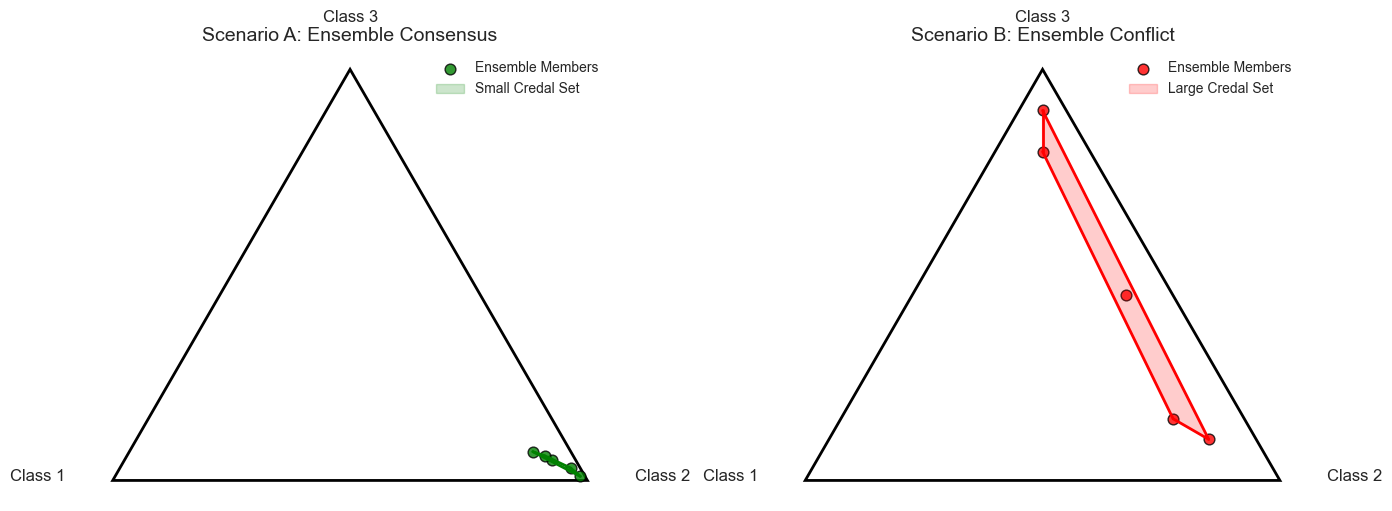

In [ ]:
# --- SCENARIO A: Consensus ---
# 5 models, all very sure it's Class 2 (index 1)
# Format: [p_class1, p_class2, p_class3] # noqa : ERA001
ensemble_consensus = np.array(
    [[0.05, 0.90, 0.05], [0.02, 0.95, 0.03], [0.08, 0.85, 0.07], [0.01, 0.98, 0.01], [0.06, 0.88, 0.06]]
)

# --- SCENARIO B: High Conflict (Epistemic Uncertainty) ---
# Models disagree: Some say Class 2, some say Class 3, one is undecided
ensemble_conflict = np.array(
    [
        [0.10, 0.80, 0.10],  # Thinks Class 2
        [0.10, 0.10, 0.80],  # Thinks Class 3
        [0.15, 0.70, 0.15],  # Thinks Class 2
        [0.05, 0.05, 0.90],  # Thinks Class 3
        [0.10, 0.45, 0.45],  # Undecided
    ]
)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot A
plot_simplex(ax1, title="Scenario A: Ensemble Consensus")
plot_credal_set(ax1, ensemble_consensus, color="green", label="Small Credal Set")
ax1.legend(loc="upper right")

# Plot B
plot_simplex(ax2, title="Scenario B: Ensemble Conflict")
plot_credal_set(ax2, ensemble_conflict, color="red", label="Large Credal Set")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

### Interpreting the Results

#### 1. The Green Region (Consensus)
The set is tiny.
* **Interpretation:** The models agree. We have low epistemic uncertainty. The mean prediction is reliable.

#### 2. The Red Region (Conflict)
The set spans a large area across the simplex.
* **Interpretation:** The models fundamentally disagree.
* **The "Average" Problem:** If you calculate the mean of Scenario B, you might get a point near the middle (e.g., $[0.1, 0.45, 0.45]$). This looks like standard noise.
* **The Credal Advantage:** The **size** of the red area tells us this is not just noise—it is a lack of knowledge (Epistemic Uncertainty).

#### Conclusion
By using Credal Sets with Ensembles, we can detect when our models are "arguing" with each other. This allows us to flag data points for human review instead of making confident but wrong errors.